In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick # For percentage formatting
from matplotlib.gridspec import GridSpec
import seaborn as sns # For despine

In [5]:
import plot_style
import importlib
importlib.reload(plot_style) # Reload to ensure latest changes
plot_style.activate_plot_style()


Custom plot style 'publication_quality_plots' applied.


In [7]:
df = pd.read_parquet("../data/movies.parquet")

FOCUS_GENRES = plot_style.MOVIE_GENRES

In [9]:
df.columns

Index(['title_id', 'title', 'original_title', 'release_year',
       'runtime_minutes', 'genre', 'imdb_rating', 'vote_count',
       'production_country'],
      dtype='object')

In [10]:
df['production_country']

0         AU
1         US
2         AU
3         FR
4         GB
          ..
289145    AE
289146    IT
289147    MX
289148    ID
289149    IN
Name: production_country, Length: 289150, dtype: object

In [19]:
# %%
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import seaborn as sns # For despine, though less critical for maps
import geodatasets

In [20]:
# Assuming plot_style.py is in the same directory or Python path
import plot_style
import importlib
importlib.reload(plot_style) # Reload to ensure latest changes


<module 'plot_style' from '/Users/frederikreimert/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/Kandidat_DTU/2025F/02806 Social Data Analysis and Visualization/final_project/social_data_final_project/plot_style.py'>

In [13]:
# Apply the custom plot style (mainly for colors and fonts if they affect legend/title)
# The activate_plot_style or setup_publication_quality_plots function
if hasattr(plot_style, 'activate_plot_style'):
    plot_style.activate_plot_style()
elif hasattr(plot_style, 'setup_publication_quality_plots'):
    plot_style.setup_publication_quality_plots()
else:
    print("Plot style setup function not found in plot_style module.")

Custom plot style 'publication_quality_plots' applied.


In [14]:
df = pd.read_parquet("../data/movies.parquet")

In [15]:
# %%
FOCUS_GENRES = plot_style.MOVIE_GENRES
GENRE_COLOR_MAP = plot_style.GENRE_COLOR_MAP

In [16]:
# %% Data Preparation for Map
# 1. Clean and explode genres
df_map_prep = df[['production_country', 'genre']].copy()
df_map_prep.dropna(subset=['production_country', 'genre'], inplace=True)

df_map_prep['genre'] = df_map_prep['genre'].astype(str).str.split(',')
df_exploded_genres = df_map_prep.explode('genre')
df_exploded_genres['genre'] = df_exploded_genres['genre'].str.strip()

# 2. Filter by FOCUS_GENRES
df_focus = df_exploded_genres[df_exploded_genres['genre'].isin(FOCUS_GENRES)]

# 3. Count movies per country and genre
country_genre_counts = df_focus.groupby(['production_country', 'genre']).size().reset_index(name='count')

# 4. Find the dominant genre for each country
# Sort by count descending, then take the first for each country
dominant_genre_per_country = country_genre_counts.sort_values('count', ascending=False) \
                                                .groupby('production_country').first().reset_index()
dominant_genre_per_country = dominant_genre_per_country[['production_country', 'genre', 'count']]
dominant_genre_per_country.rename(columns={'genre': 'dominant_genre', 'count': 'dominant_genre_movie_count'}, inplace=True)

In [23]:
# %% Load Geospatial Data using geodatasets

# Primary dataset name for low-resolution Natural Earth countries
dataset_name = "naturalearth_lowres"

try:
    world_boundaries_path = geodatasets.get_path(dataset_name)
    print(f"Successfully loaded dataset: {dataset_name}")
except ValueError:
    print(f"Dataset '{dataset_name}' not found directly. Checking available datasets...")
    # List some available datasets from geodatasets. This can be a long list.
    # For brevity, we won't print all, but this is how you'd check:
    # from geodatasets import data
    # print("Available datasets in geodatasets include:")
    # for key in data: print(key) # This would print all top-level keys
    #
    # Natural Earth datasets are often prefixed, e.g., for land polygons:
    # geodatasets.get_path("naturalearth.land")
    # For cities: geodatasets.get_path("naturalearth.cities")
    # It's possible the direct 'naturalearth_lowres' is available or one needs to specify
    # a sub-dataset. Let's try 'naturalearth.land' as another common one.
    try:
        dataset_name_alt = "naturalearth.land" # This provides land polygons, not necessarily country boundaries with attributes
        print(f"Attempting to load alternative: {dataset_name_alt}")
        world_boundaries_path = geodatasets.get_path(dataset_name_alt)
        print(f"Successfully loaded dataset: {dataset_name_alt}")
        # NOTE: "naturalearth.land" might not have the iso_a2 or name attributes we expect for countries.
        # "naturalearth_lowres" is usually the one with country attributes.
        # If "naturalearth_lowres" fails, it's a significant issue with the geodatasets setup or version.
    except ValueError as e_alt:
        print(f"Alternative dataset '{dataset_name_alt}' also not found.")
        raise ValueError(
            f"Could not find '{dataset_name}' or '{dataset_name_alt}'. "
            "Please ensure 'geodatasets' is installed correctly and the dataset name is valid. "
            "You might need to check the geodatasets documentation for the exact names of Natural Earth datasets."
        ) from e_alt


world = geopandas.read_file(world_boundaries_path)

# --- Crucial: Identify the correct ISO A2 column ---
# Common names for ISO A2 in Natural Earth datasets provided by geodatasets:
# For 'naturalearth_lowres', 'iso_a2' is standard.
iso_a2_col_candidates = ['iso_a2', 'ISO_A2', 'ISO_A2_EH', 'ADM0_A2']
iso_a2_col = None
for col_name in iso_a2_col_candidates:
    if col_name in world.columns:
        iso_a2_col = col_name
        break

if iso_a2_col is None:
    # If 'naturalearth.land' was loaded, it might not have ISO codes.
    # 'naturalearth_lowres' should.
    raise ValueError(
        f"Could not find a suitable ISO A2 country code column in the loaded dataset ('{dataset_name}' or alternative). "
        f"Columns found: {world.columns}. 'naturalearth_lowres' is expected to have 'iso_a2'."
    )
print(f"Using '{iso_a2_col}' as the ISO A2 country code column from the shapefile.")


# Filter out entries where the ISO A2 code is problematic (e.g., -99, NaN)
# Also ensure pop_est exists and filter by it if you want (not all datasets have pop_est)
# 'pop_est' and 'name' are expected in 'naturalearth_lowres'
if 'pop_est' in world.columns and 'name' in world.columns:
    world = world[(world['pop_est'] > 0) & (world[iso_a2_col] != '-99') & (world[iso_a2_col].notna())]
elif 'name' in world.columns: # Fallback if pop_est is missing, but iso_a2 is key
    print("Warning: 'pop_est' column not found in world dataset. Filtering without it.")
    world = world[(world[iso_a2_col] != '-99') & (world[iso_a2_col].notna())]
else:
    raise ValueError(f"Essential columns ('name' or '{iso_a2_col}') not found in the world dataset.")


# %% Merge movie data with geospatial data
world_merged = world.merge(dominant_genre_per_country,
                           left_on=iso_a2_col, # Use the identified ISO A2 column
                           right_on='production_country',
                           how='left')

world_merged['color'] = world_merged['dominant_genre'].map(GENRE_COLOR_MAP).fillna('lightgrey')

# %% Plotting the Map
# (This part remains largely the same as before, ensure legend uses FOCUS_GENRES from plot_style)
fig, ax = plt.subplots(1, 1, figsize=(18, 10))

world_merged.plot(ax=ax,
                  color=world_merged['color'],
                  linewidth=0.5,
                  edgecolor='0.3',
                  legend=False,
                  missing_kwds={ # For countries not in dominant_genre_per_country if 'color' column wasn't pre-filled
                      "color": "lightgrey",
                      "edgecolor": "0.5",
                      "hatch": "///",
                      "label": "No Data",
                  })

legend_patches = []
# Use plot_style.FOCUS_GENRES for legend to ensure consistency if defined there
# or the local FOCUS_GENRES if that's intended
genres_for_legend = plot_style.FOCUS_GENRES if hasattr(plot_style, 'FOCUS_GENRES') else FOCUS_GENRES

plotted_genres_in_data = world_merged[world_merged['dominant_genre'].notna()]['dominant_genre'].unique()

for genre in genres_for_legend:
    if genre in plotted_genres_in_data:
        color = GENRE_COLOR_MAP.get(genre, 'black')
        legend_patches.append(plt.Rectangle((0, 0), 1, 1, fc=color, label=genre))

if world_merged['dominant_genre'].isna().any():
    legend_patches.append(plt.Rectangle((0, 0), 1, 1, fc='lightgrey', label='No Movie Data / Other'))


if legend_patches:
    ax.legend(handles=legend_patches,
              title="Most Frequent Movie Genre",
              loc='lower left', # Or 'best', 'upper left' etc.
              bbox_to_anchor=(0.01, 0.01), # Fine-tune position (x, y, width, height from axes fraction)
              frameon=False,
              fontsize=9,
              title_fontsize=11)
else:
    print("No data to create a legend for.")


ax.set_title('Dominant Movie Genre by Production Country', fontsize=18, pad=15)
ax.set_axis_off() # Remove axis ticks and labels

plt.tight_layout()
plt.show()

# %% Print some info for verification
print("\nDominant genres found:")
print(dominant_genre_per_country.head())
print(f"\nNumber of countries with dominant genre data: {world_merged['dominant_genre'].notna().sum()}")
print(f"Number of countries plotted as 'No Data': {world_merged['dominant_genre'].isna().sum()}")

# Use 'name' column for country name if available, otherwise use the iso_a2_col
name_col_for_print = 'name' if 'name' in world_merged.columns else iso_a2_col
print(f"\nSample of merged data with colors (using '{name_col_for_print}' for country name):")
print(world_merged[[name_col_for_print, iso_a2_col, 'dominant_genre', 'color']].dropna(subset=['dominant_genre']).head())

Dataset 'naturalearth_lowres' not found directly. Checking available datasets...
Attempting to load alternative: naturalearth.land
Successfully loaded dataset: naturalearth.land


ValueError: Could not find a suitable ISO A2 country code column in the loaded dataset ('naturalearth_lowres' or alternative). Columns found: Index(['featurecla', 'scalerank', 'min_zoom', 'geometry'], dtype='object'). 'naturalearth_lowres' is expected to have 'iso_a2'.

In [24]:
import geodatasets
from geodatasets import data
print("Available top-level keys in geodatasets.data:")
for key in data:
    print(key)

# Specifically check for naturalearth related datasets
print("\nLooking for 'naturalearth' in available datasets:")
if hasattr(data, 'naturalearth'):
    print("Found 'naturalearth' collection. Available sub-datasets:")
    for sub_key in data.naturalearth:
        print(f"  - naturalearth.{sub_key}")
else:
    print("'naturalearth' collection not found directly under data.")

Available top-level keys in geodatasets.data:
geoda
ny
eea
abs
naturalearth

Looking for 'naturalearth' in available datasets:
Found 'naturalearth' collection. Available sub-datasets:
  - naturalearth.land


In [25]:
import geodatasets
from geodatasets import data # data is an instance of Bunch

print("--- Geodatasets Top-Level Keys ---")
for key in data:
    print(key)

print("\n--- Exploring 'naturalearth' if it exists ---")
if 'naturalearth' in data: # Check if 'naturalearth' is a direct key
    print("Found 'naturalearth' as a top-level key. Sub-items:")
    # Accessing data.naturalearth might try to load/index it if it's a special object
    try:
        ne_collection = data.naturalearth
        if isinstance(ne_collection, geodatasets.lib.Dataset):
            print(f"  'naturalearth' is a Dataset object itself: {ne_collection.name}")
        else: # Assuming it's a collection (another Bunch)
            for sub_key in ne_collection:
                print(f"  naturalearth.{sub_key}")
                # You could even try to get the path here to see if it loads
                # try:
                #     path = geodatasets.get_path(f"naturalearth.{sub_key}")
                #     print(f"    -> Path: {path}")
                #     gdf_test = geopandas.read_file(path)
                #     print(f"    -> Columns: {gdf_test.columns.tolist()}")
                # except Exception as e:
                #     print(f"    -> Error loading naturalearth.{sub_key}: {e}")
    except Exception as e:
        print(f"Error accessing or iterating data.naturalearth: {e}")
else:
    print("'naturalearth' collection not found as a direct top-level key.")

print("\n--- Checking for 'naturalearth_lowres' directly ---")
if 'naturalearth_lowres' in data:
    print("Found 'naturalearth_lowres' as a top-level key.")
    try:
        dataset_obj = data.naturalearth_lowres
        print(f"  Dataset object: {dataset_obj.name}")
        # path = geodatasets.get_path("naturalearth_lowres") # Should be same as dataset_obj.path
        # gdf_test = geopandas.read_file(path)
        # print(f"  Columns for 'naturalearth_lowres': {gdf_test.columns.tolist()}")
    except Exception as e:
        print(f"  Error accessing or loading 'naturalearth_lowres': {e}")
else:
    print("'naturalearth_lowres' not found as a top-level key.")

# Also, let's try getting the path for "naturalearth_lowres" again and inspect its columns
# if the previous error was intermittent or due to a different context.
print("\n--- Re-attempting 'naturalearth_lowres' load and column inspection ---")
try:
    path_nlr = geodatasets.get_path("naturalearth_lowres")
    print(f"Path for 'naturalearth_lowres': {path_nlr}")
    world_test_nlr = geopandas.read_file(path_nlr)
    print(f"Columns in 'naturalearth_lowres' GeoDataFrame: {world_test_nlr.columns.tolist()}")
except Exception as e:
    print(f"Error loading 'naturalearth_lowres' this time: {e}")

--- Geodatasets Top-Level Keys ---
geoda
ny
eea
abs
naturalearth

--- Exploring 'naturalearth' if it exists ---
Found 'naturalearth' as a top-level key. Sub-items:
  naturalearth.land

--- Checking for 'naturalearth_lowres' directly ---
'naturalearth_lowres' not found as a top-level key.

--- Re-attempting 'naturalearth_lowres' load and column inspection ---
Error loading 'naturalearth_lowres' this time: No matching item found for the query 'naturalearth_lowres'.


Successfully loaded shapefile from: ../data/shapefile/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp
Columns found in manual shapefile: ['featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3', 'ADM0_DIF', 'LEVEL', 'TYPE', 'TLC', 'ADMIN', 'ADM0_A3', 'GEOU_DIF', 'GEOUNIT', 'GU_A3', 'SU_DIF', 'SUBUNIT', 'SU_A3', 'BRK_DIFF', 'NAME', 'NAME_LONG', 'BRK_A3', 'BRK_NAME', 'BRK_GROUP', 'ABBREV', 'POSTAL', 'FORMAL_EN', 'FORMAL_FR', 'NAME_CIAWF', 'NOTE_ADM0', 'NOTE_BRK', 'NAME_SORT', 'NAME_ALT', 'MAPCOLOR7', 'MAPCOLOR8', 'MAPCOLOR9', 'MAPCOLOR13', 'POP_EST', 'POP_RANK', 'POP_YEAR', 'GDP_MD', 'GDP_YEAR', 'ECONOMY', 'INCOME_GRP', 'FIPS_10', 'ISO_A2', 'ISO_A2_EH', 'ISO_A3', 'ISO_A3_EH', 'ISO_N3', 'ISO_N3_EH', 'UN_A3', 'WB_A2', 'WB_A3', 'WOE_ID', 'WOE_ID_EH', 'WOE_NOTE', 'ADM0_ISO', 'ADM0_DIFF', 'ADM0_TLC', 'ADM0_A3_US', 'ADM0_A3_FR', 'ADM0_A3_RU', 'ADM0_A3_ES', 'ADM0_A3_CN', 'ADM0_A3_TW', 'ADM0_A3_IN', 'ADM0_A3_NP', 'ADM0_A3_PK', 'ADM0_A3_DE', 'ADM0_A3_GB', 'ADM0_A3_BR', 'ADM0_A3_IL'

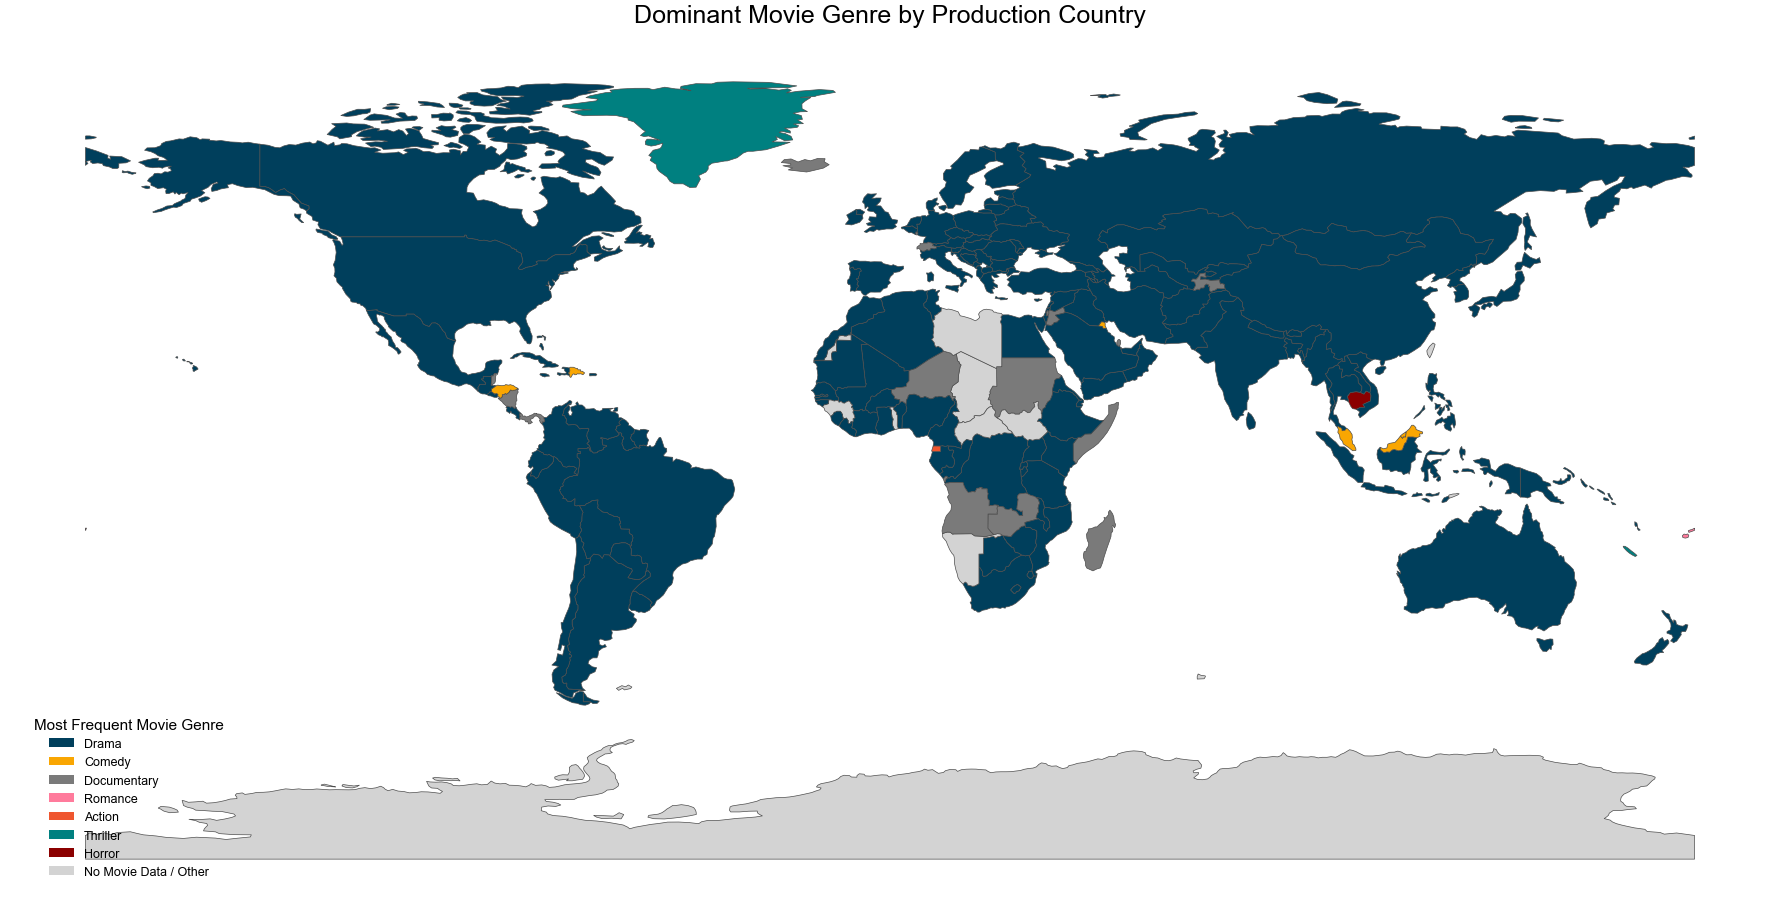


Dominant genres found in movie data:
  production_country dominant_genre  dominant_genre_movie_count
0                 AD          Drama                           2
1                 AE          Drama                         616
2                 AF          Drama                          18
3                 AG       Thriller                           1
4                 AL          Drama                          83

Number of countries in map with dominant genre data: 159
Number of countries in map plotted as 'No Data': 13

Sample of merged map data with colors (using 'NAME' for country name):
                       NAME ISO_A2 dominant_genre    color
0                      Fiji     FJ        Romance  #ff7b9c
1                  Tanzania     TZ          Drama  #003f5c
3                    Canada     CA          Drama  #003f5c
4  United States of America     US          Drama  #003f5c
5                Kazakhstan     KZ          Drama  #003f5c


In [29]:
# %%
FOCUS_GENRES = plot_style.MOVIE_GENRES
GENRE_COLOR_MAP = plot_style.GENRE_COLOR_MAP

# %% Data Preparation for Map (Dominant Genre per Country)
df_map_prep = df[['production_country', 'genre']].copy()
df_map_prep.dropna(subset=['production_country', 'genre'], inplace=True)
df_map_prep['genre'] = df_map_prep['genre'].astype(str).str.split(',')
df_exploded_genres = df_map_prep.explode('genre')
df_exploded_genres['genre'] = df_exploded_genres['genre'].str.strip()
df_focus = df_exploded_genres[df_exploded_genres['genre'].isin(FOCUS_GENRES)]
country_genre_counts = df_focus.groupby(['production_country', 'genre']).size().reset_index(name='count')
dominant_genre_per_country = country_genre_counts.sort_values('count', ascending=False) \
                                                .groupby('production_country').first().reset_index()
dominant_genre_per_country = dominant_genre_per_country[['production_country', 'genre', 'count']]
dominant_genre_per_country.rename(columns={'genre': 'dominant_genre', 'count': 'dominant_genre_movie_count'}, inplace=True)

# %% Load Geospatial Data MANUALLY
# *** ADJUST THIS PATH to where you extracted the Natural Earth countries shapefile ***
# It should point to the .shp file.
manual_shapefile_path = "../data/shapefile/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp"

try:
    world = geopandas.read_file(manual_shapefile_path)
    print(f"Successfully loaded shapefile from: {manual_shapefile_path}")
    print(f"Columns found in manual shapefile: {world.columns.tolist()}")
except Exception as e:
    raise FileNotFoundError(
        f"Could not load the manual shapefile. Error: {e}. "
        f"Please check the path: {manual_shapefile_path}. "
        "Ensure you have downloaded and extracted the 'Admin 0 – Countries' shapefile from Natural Earth."
    )

# Identify the ISO A2 column from the manually downloaded shapefile
# Common names for ISO A2 in Natural Earth Admin 0 Countries: 'ISO_A2', 'ADM0_A3_IS' (less common for this file)
# Let's be explicit for the standard Natural Earth file:
iso_a2_col_ne = 'ISO_A2' # This is typically the column name in ne_110m_admin_0_countries
if iso_a2_col_ne not in world.columns:
    # Fallback search if the expected one isn't there (unlikely for this specific file)
    print(f"Warning: Expected column '{iso_a2_col_ne}' not found. Searching for alternatives...")
    iso_a2_col_candidates = ['iso_a2', 'ISO_A2_EH', 'ADM0_A2']
    iso_a2_col = None
    for col_name in iso_a2_col_candidates:
        if col_name in world.columns:
            iso_a2_col = col_name
            break
    if iso_a2_col is None:
        raise ValueError(f"Could not find a suitable ISO A2 country code column in the manually loaded shapefile. Columns found: {world.columns}")
    iso_a2_col_ne = iso_a2_col # Use the found alternative

print(f"Using '{iso_a2_col_ne}' as the ISO A2 country code column from the shapefile.")

# Filter out entries with problematic ISO A2 codes (Natural Earth uses -99)
# and optionally by population if 'POP_EST' is available and desired.
world = world[(world[iso_a2_col_ne] != '-99') & (world[iso_a2_col_ne].notna())]
if 'POP_EST' in world.columns: # 'POP_EST' is in this Natural Earth file
    world = world[world['POP_EST'] > 0]

# %% Merge movie data with geospatial data
world_merged = world.merge(dominant_genre_per_country,
                           left_on=iso_a2_col_ne, # Use the identified ISO A2 column
                           right_on='production_country',
                           how='left') # Left merge to keep all countries

world_merged['color'] = world_merged['dominant_genre'].map(GENRE_COLOR_MAP).fillna('lightgrey') # Lightgrey for no data

# %% Plotting the Map
fig, ax = plt.subplots(1, 1, figsize=(18, 10))

world_merged.plot(ax=ax,
                  color=world_merged['color'],
                  linewidth=0.5,
                  edgecolor='0.3', # Dark grey border for countries
                  legend=False)   # Custom legend below

# Custom Legend
legend_patches = []
plotted_genres_in_data = world_merged[world_merged['dominant_genre'].notna()]['dominant_genre'].unique()
genres_for_legend = FOCUS_GENRES # Assuming FOCUS_GENRES is defined and from plot_style

for genre in genres_for_legend:
    if genre in plotted_genres_in_data:
        color = GENRE_COLOR_MAP.get(genre, 'black')
        legend_patches.append(plt.Rectangle((0, 0), 1, 1, fc=color, label=genre))

if world_merged['dominant_genre'].isna().any():
    legend_patches.append(plt.Rectangle((0, 0), 1, 1, fc='lightgrey', label='No Movie Data / Other'))

if legend_patches:
    ax.legend(handles=legend_patches, title="Most Frequent Movie Genre",
              loc='lower left', bbox_to_anchor=(0.01, 0.01),
              frameon=False, fontsize=9, title_fontsize=11)

# Map Styling
country_name_col = 'NAME' # Standard name column in ne_110m_admin_0_countries
ax.set_title('Dominant Movie Genre by Production Country', fontsize=18, pad=15)
ax.set_axis_off()
plt.tight_layout()
plt.show()

# Print some info for verification
print("\nDominant genres found in movie data:")
print(dominant_genre_per_country.head())
print(f"\nNumber of countries in map with dominant genre data: {world_merged['dominant_genre'].notna().sum()}")
print(f"Number of countries in map plotted as 'No Data': {world_merged['dominant_genre'].isna().sum()}")
if country_name_col in world_merged.columns:
    print(f"\nSample of merged map data with colors (using '{country_name_col}' for country name):")
    print(world_merged[[country_name_col, iso_a2_col_ne, 'dominant_genre', 'color']].dropna(subset=['dominant_genre']).head())
else:
    print(f"\nNote: Country name column '{country_name_col}' not found for printing sample.")
